In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-08-31_21-36_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.09416628387689481

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

ES       0.25
NQ       0.25
YM       0.25
GC       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    19873.70
GC     4416.72
NQ    31660.20
YM    27461.60
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

83412.22

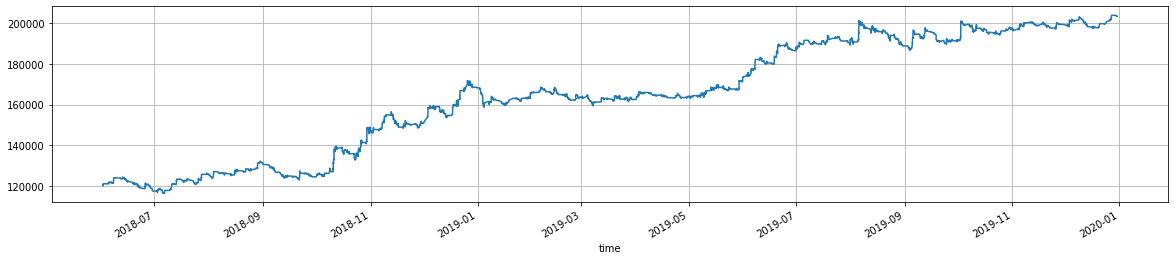

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     578
 GC    1084
 NQ    2088
 YM     604
 Name: action, dtype: int64,
 4354)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.402913
 GC    2.631068
 NQ    5.067961
 YM    1.466019
 Name: action, dtype: float64,
 10.567961165048544)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1213.80
GC    2623.28
NQ    4384.80
YM    1268.40
Name: commission, dtype: float64

In [16]:
df.commission.sum()

9490.279999999999

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.39,8.15,434.59,-259.49,1.67,11.20,542.0
NQ,0.40,30.33,462.64,-252.63,1.83,33.48,1044.0
ES,0.40,68.77,934.28,-503.27,1.86,71.75,289.0
YM,0.40,90.93,770.64,-369.76,2.08,86.40,302.0
total,0.39,38.32,562.70,-303.45,1.85,34.35,2177.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,-0.011068,0.238816,0.517476,0.727072
GC,-0.011068,1.000000,0.088007,0.095105,0.377143
NQ,0.238816,0.088007,1.000000,0.215423,0.672363
YM,0.517476,0.095105,0.215423,1.000000,0.713463
total,0.727072,0.377143,0.672363,0.713463,1.000000


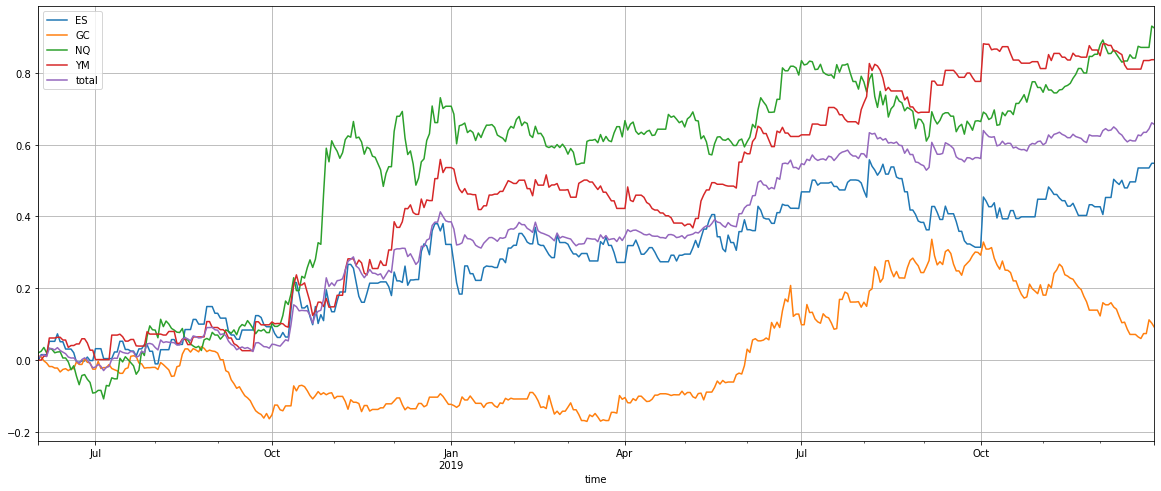

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

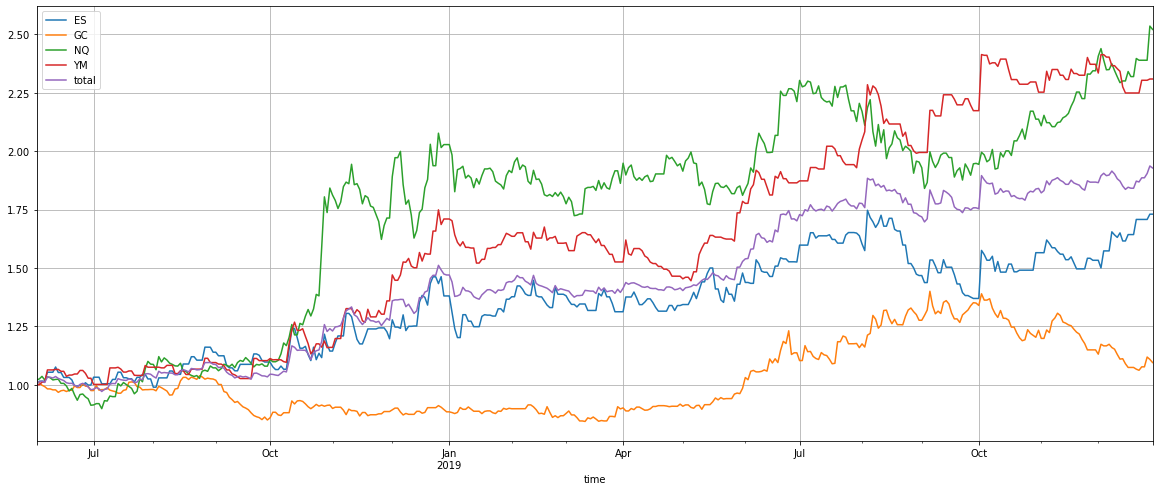

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.398437,0.057147,0.760592,0.668367,0.494145
Cumulative returns,0.730273,0.095115,1.521346,1.309027,0.928050
Annual volatility,0.378266,0.264195,0.402547,0.312978,0.218163
Sharpe ratio,1.071184,0.340846,1.603539,1.788934,1.948818
Calmar ratio,1.843339,0.236578,3.787261,3.849934,4.980862
Stability,0.853445,0.453966,0.742543,0.936031,0.937804
Max drawdown,-0.216150,-0.241557,-0.200829,-0.173605,-0.099209
Omega ratio,1.262773,1.066595,1.349460,1.527290,1.478663
Sortino ratio,2.001429,0.568370,2.842859,3.911772,4.122780
Skew,1.593229,0.946122,1.171512,2.034551,2.016533


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,-0.13,-2.49,-8.78,2.80,-2.13
2018-07-31,2.62,0.49,19.30,4.59,6.77
2018-08-31,11.17,4.55,-1.46,1.85,4.13
2018-09-30,-3.69,-17.11,0.69,0.75,-4.99
2018-10-31,4.27,7.52,70.63,5.14,19.96
2018-11-30,4.61,-3.04,-6.97,17.16,2.91
2018-12-31,15.32,-0.14,18.35,25.80,15.19
2019-01-31,-1.02,1.72,-5.46,-3.92,-1.94
2019-02-28,1.56,-3.55,-5.82,-2.24,-2.37


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        73.0
GC        10.0
NQ       152.0
YM       131.0
total     93.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:49:00,ES,BUY,2893.50,4508.30
2018-10-11 04:24:00,ES,BUY,2767.00,3395.80
2019-10-02 20:45:00,YM,BUY,26062.00,3315.80
2019-06-20 03:04:00,GC,SELL,1392.40,3105.16
2018-10-31 15:48:00,NQ,SELL,6989.50,2965.80
...,...,...,...,...
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.20
2018-12-26 11:04:00,ES,BUY,2360.75,-1454.20
2019-01-02 16:09:00,ES,BUY,2488.75,-1529.20


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-10-02,0.150277,0.037355,0.026633,0.110527,0.081198
2019-09-05,0.067220,0.061011,0.070387,0.090387,0.072251
2019-08-05,0.109720,0.043839,0.035793,0.096720,0.071518
2018-12-03,0.067777,0.008011,0.103553,0.081860,0.065300
2018-10-29,0.089860,-0.005495,0.136633,0.022887,0.060971
...,...,...,...,...,...
2018-10-30,-0.036807,0.004172,-0.037253,-0.024307,-0.023549
2019-02-14,-0.045420,-0.013656,-0.020447,-0.014973,-0.023624
2019-10-09,-0.041530,-0.017828,-0.041893,0.000000,-0.025313
